In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Convolutional Neural Networks
This challenge is going to be a bit more, well... challenging. You are going to process image data and use Convolutional Neural Networks. These types of algorithms are designed to use multidimensional data where the spatial relations between the dimensions are relevant. Or in other words, good with pretty pictures.

Today we are going to use the MNIST dataset, probably the most famous dataset in all of AI. It consists of 28x28 pixel pictures of handwritten numbers in greyscale (black & white).

We are going to use some real Deep Learning here that benefits from GPU acceleration. Luckily Colab can provide us with a free GPU to train the neural networks faster. You can activate GPU acceleration in the Runtime tab: Runtime -> Change runtime type -> Select GPU from the dropdown



In [2]:
# Download the dataset
from keras.datasets import mnist, fashion_mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print(X_train.shape)
print(X_test.shape)

11490434/11490434 [==============================] - 2s 0us/step
(60000, 28, 28)
(10000, 28, 28)


5


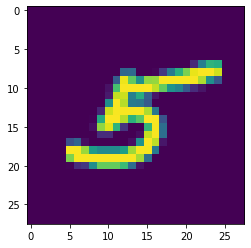

In [3]:
# View example digit
index = np.random.randint(0,60000)
plt.imshow(X_train[index])
print(y_train[index])

### Reshaping the data
CNNs expect the data to be in a specific shape depending on the number of dimensions. Since we work with image data, we will use 2D CNN layers. The expected shape that would be as follows (number_of_samples, dimension_size_1, dimension_size_2, channel). Looking at X_train. The shape above the first 3 is easy to derive. The number of training samples is 60000 and the images are 28*28 and therefore those would be the two dimension sizes. Channel would basically be the number of spectral wavelengths are in the data. For colored images this is 3 (red, green, blue) for greyscale images this would just be 1, and for multispectral satellite images, this could be many more. In this case, we have black and white images, so we end up with the desired X_train shape of (60000,28,28,1). This is not the shape of our data as can be seen above, that would be (60000,28,28). This is because it has the intensity value in the second dimension instead of it being just a coordinate and an extra dimension for the intensity. Luckily we can easily reshape the data to our desired format.

In [ ]:
# Put it into suitable shape
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

In [ ]:
# Use one hot encoding to covert the labels
from sklearn.preprocessing import LabelBinarizer

### Architecture
Now for the architecture

- This time we defined the input in a separate Input Layer, which results in exactly the same as when you define input_shape in the first layer.
- Then we do a single Convolutional layer
- The last layer should stay a Dense layer with the number of classes for neurons just like with the previous. However, we can not just push 2D data into a 1D Dense layer therefore we need to Flatten the data using a Flatten layer.


Configuring the Conv2D layers will require some fiddling, here is the documentation:
https://keras.io/api/layers/convolution_layers/convolution2d/
<br><br>
You should at least define a **filter size**. To keep it simple, this number determines the amount of information that will be collected per output "pixel" in the output. So a higher number means more space for information but also longer compute times and larger model size. 
<br><br>
Then you should also define a **kernel size** (also known as window) Which basically determines how much information is condensed into an output "pixel". This means that larger kernels result in a larger segment of the image will be cramped into a smaller resulting image. So here larger means less information pushed to the next layer. 

**Warning:** When adding Conv layers and changing kernel sizes you impact the shape of de "image" that is passed to the next layers, often making it smaller. This means that when you stack too many layers and/or use large kernel sizes, the image at some point will become smaller than 0x0 resulting in a crash. You can simply calculate the effect each propagating layer will have on the image but you can also pay extra attention to the model summary since that will show the resulting image dimensions after each layer.
 


In [4]:
from tensorflow import keras
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, 
                                     Dense, Dropout, BatchNormalization, Activation)

In [1]:
def define_cnn(input_shape, num_classes):
    # Build the architecture
    model = keras.Sequential()

    # first CONV => RELU => CONV => RELU 
    model.add(Conv2D(32, (3, 3), padding="same",
        input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    # second CONV => RELU => CONV => RELU
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation("relu"))
    # softmax classifier
    model.add(Dense(num_classes))
    model.add(Activation("softmax"))

    model.summary()
    return model



### Training the network
For the optimizer we will use classic Stochastic Gradient Descent. There exist more advanced optimizers like Adam, but we will skip those for now. The loss defines how we punish the network for a mistake. Without going into the details Categorical Crossentropy is generally used with classification.

In [ ]:
from keras.datasets import mnist, fashion_mnist
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, 
                                     Dense, Dropout, BatchNormalization, Activation)
from sklearn.preprocessing import LabelBinarizer

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_epochs = 10
batch_size = 32
input_shape = X_train.shape[1:]
num_classes = y_train.shape[-1]


def define_cnn(input_shape, num_classes):
    model = keras.Sequential()

    # first CONV => RELU => CONV => RELU 
    model.add(Conv2D(32, (3, 3), padding="same",
        input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    # second CONV => RELU => CONV => RELU
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation("relu"))
    # softmax classifier
    model.add(Dense(num_classes))
    model.add(Activation("softmax"))

    model.summary()
    return model

model = define_cnn(input_shape, num_classes)
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
# Train and test
H = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_test, y_test))

In [21]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.037927333265542984
Test accuracy: 0.9915000200271606


## **Assignment:** Tune the CNN
2.1: Add convolutional layers, change kernel and filter sizes to get to a 98% accuracy on the test dataset

2.2: Go back to the data loader and change the MNIST loader to the Fashion MNIST loader "fashion_mnist.load_data()". Tune the parameters until you reach an accuracy of 87% on the test dataset.

2.3 (Advanced): Include max-pooling, dropout, and batch normalization layers to reach a test accuracy of 90% on the test set.





In [ ]:
# 2.1 ------------------------------------------------------------------------------------
from keras.datasets import mnist, fashion_mnist
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, 
                                     Dense, Dropout, BatchNormalization, Activation)
from sklearn.preprocessing import LabelBinarizer

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_epochs = 10
batch_size = 32
input_shape = X_train.shape[1:]
num_classes = y_train.shape[-1]



def define_cnn(input_shape, num_classes):
    model = keras.Sequential()

    # first CONV => RELU => CONV => RELU 
    model.add(Conv2D(32, (2, 2), padding="same",
        input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (2, 2), padding="same"))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    # second CONV => RELU => CONV => RELU

    model.add(Conv2D(64, (2,2), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(64, (2,2), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation("relu"))
    # softmax classifier
    model.add(Dense(num_classes))
    model.add(Activation("softmax"))

    model.summary()
    return model



modelA = define_cnn(input_shape, num_classes)
modelA.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
# Train and test
H = modelA.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_test, y_test))
score = modelA.evaluate(X_test, y_test, verbose=0)
print("MNIST DATA: ")
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# 2.2-----------------------------------------------------------------------------------------------------

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_epochs = 10
batch_size = 32
input_shape = X_train.shape[1:]
num_classes = y_train.shape[-1]

modelB = define_cnn(input_shape, num_classes)
modelB.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
# Train and test
H = modelB.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_test, y_test))
score = modelB.evaluate(X_test, y_test, verbose=0)
print("FASHION MNIST DATA: ")
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 28, 28, 32)        160       
                                                                 
 activation_54 (Activation)  (None, 28, 28, 32)        0         
                                                                 
 dropout_2 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 conv2d_41 (Conv2D)          (None, 28, 28, 32)        4128      
                                                                 
 activation_55 (Activation)  (None, 28, 28, 32)        0         
                                                                 
 dropout_3 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 conv2d_42 (Conv2D)          (None, 28, 28, 64)       